# Phase 2 - Muliticlass classifier to predict death time for in-hospital mortality

We propose to a two-phase model framework to predict in-hospital mortality and death time in hours. This notebook presents the machine learning pipeline for model training, hyperparameter tuning and model evaluation in Phase 2. In Phase 2, a multiclass classifier was trained to predict death time in hours since ICU admission using the same set of extracted features in Phase 1 (i.e. the 123 features extracted from the previous stage of feature engineering in Hive). 

* Part 1. Define classes and methods for the machine learning pipieline
* Part 2. Model training and evaluation using 6-hour, 12-hour, 24-hour data

In [6]:
import pandas as pd
import numpy as np
from scipy import interp
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer, Imputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
import sklearn.multiclass
from itertools import cycle
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams.update({'font.size': 16})

---
## Part 1. Define classes and methods for the machine learning pipieline

Similar to Phase 1, we first define the classes of `CustomLabelBinarizer`, `ItemSelector` and `MultiItemSelector` for custom data transformation in sklearn pipieline. Specifically,

* `CustomLabelBinarizer` converts multi-class labels to binary labels.
* `ItemSelector` and `MultiItemSelector` select custom features from the input dataframe.

In [13]:
unseen_label = "__New__"
seed = 200

class CustomLabelBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.le = LabelEncoder()
        self.lb = LabelBinarizer()
        self.seen_labels = set()
        
    def fit(self, x, y=None,**fit_params):
        self.seen_labels = set(x)
        self.seen_labels.add(unseen_label)
        
        # add "unseen" to X
        x_new = list(x)
        x_new.append(unseen_label)

        label_encoded = self.le.fit_transform(x_new)
        self.lb.fit(label_encoded)
        return self
    
    def transform(self, x):
        x_new = list(map(lambda label: label if label in self.seen_labels else unseen_label, list(x)))
        label_encoded = self.le.transform(x_new)
        return self.lb.transform(label_encoded)
    
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, df):
        return df[self.key]

    
class MultiItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key_list):
        self.key_list = key_list

    def fit(self, x, y=None):
        return self

    def transform(self, df):
        return df[self.key_list]

Next, we define two useful methods `descretize()` and `evaluate()` for data transformation and model evaluation. Note that `hosp_deathtime_hours` is the death time in hours since ICU admission. We will train classifiers to predict the multiclass labels based on this variable.

* `descretize()` transforms numerical values into multiclass labels {0,1,2} with cutoff parameters.
* `evaluate()` evaluates the model performance and prints a detailed report of the performance metrics e.g. accuracy, AUC score, precision, recall and F1 score.

In [14]:
def descretize(x, cutoff1, cutoff2):
    if x < cutoff1:
        return 0
    elif x < cutoff2:
        return 1
    else: 
        return 2

def evaluate(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    precision_micro = precision_score(y_true, y_pred, average='micro')
    precision_macro = precision_score(y_true, y_pred, average='macro')
    recall_micro = recall_score(y_true, y_pred, average='micro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    f1score_micro = f1_score(y_true, y_pred, average='micro')   
    f1score_macro = f1_score(y_true, y_pred, average='macro')  
    print ("Accuracy : {:.4f}".format(acc))
    print("Precision (Micro) : {:.4f}".format(precision_micro))
    print("Precision (Macro): {:.4f}".format(precision_macro))
    print("Recall (Micro) : {:.4f}".format(recall_micro))
    print("Recall (Macro): {:.4f}".format(recall_macro))
    print("F1 score (Micro) : {:.4f}".format(f1score_micro))
    print("F1 score (Macro): {:.4f}".format(f1score_macro))
    print("\nClassification report : \n", classification_report(y_true, y_pred))
    print("\nConfusion matrix : \n", confusion_matrix(y_true, y_pred))

Now, we are ready to define the main method `train_evaluate_model`. The method does the following:

* Filter out the ICU stays with negative death time since ICU admission (which is likely an administrative error resulting in an incorrect ICU admission or incorrect death time)
* Split data into 80% training set and 20% test set
* Build custom machine learning pipeline which 
    * select specified features from the input dataframe (`ItemSelector` and `MultiItemSelector`) 
    * transform categorical data into binary label (`CustomLabelBinarizer`) 
    * impute missing values for numerical data with median (`Imputer`)
    * train `RandomForestClassifier` using `GridSearchCV` on 5-fold CV of the training set
    * find the best parameter set from the grid search
* Evaluate the model performance using the best parameter set on the test set

Note that we also transform the numerical values of `hosp_deathtime_hours` to 3 classes using `descretize()` and fit the pipeline to predict the multiclass labels.

In [19]:
def train_evaluate_model(df):
    # set cutoff for multiclass labels
    cutoff1 = 24
    cutoff2 = 24*7
    
    # filter out ICU stays with negative death time
    # so that our model will train on dead patients with death time >= 0
    df_dead = df[(df.hospital_expire_flag==1) & (df.hosp_deathtime_hours>=0)]
    print(df.shape, df_dead.shape)
    
    # split data into 80% training set, 20% test set
    train_cv_df = df_dead.sample(frac=0.8,random_state=seed)
    test_df = df_dead.drop(train_cv_df.index)
    print(train_cv_df.shape, test_df.shape)
    
    # define the machine learning pipeline
    discrete_pipeline = Pipeline([
        ("feature_union", FeatureUnion(
            transformer_list=[
                # categorical pipeline
                ('ethnicity', Pipeline([
                    ("selector", ItemSelector(key='ethnicity')),
                    ("binarizer", CustomLabelBinarizer())
                ])),            

                ("gender", Pipeline([
                    ("selector", ItemSelector(key='gender')),
                    ("binarizer", CustomLabelBinarizer())
                ])),
                ("admission_type", Pipeline([
                    ("selector", ItemSelector(key='admission_type')),
                    ("binarizer", CustomLabelBinarizer())
                ])),

                # numerical pipeline
                ("numerical", Pipeline([
                    ("selector", MultiItemSelector(key_list=
                          ['age', 'icustay_num',
                           'heartrate_mean', 'sysbp_mean', 'diasbp_mean', 'meanbp_mean',
                           'resprate_mean', 'tempc_mean', 'spo2_mean', 'glucose_mean', 
                           'heartrate_min', 'sysbp_min', 'diasbp_min','meanbp_min', 
                           'resprate_min', 'tempc_min', 'spo2_min', 'glucose_min',
                           'heartrate_max', 'sysbp_max', 'diasbp_max', 'meanbp_max',
                           'resprate_max', 'tempc_max', 'spo2_max', 'glucose_max', 
                           'gcs_mean', 'gcsmotor_mean', 'gcsverbal_mean', 'gcseyes_mean', 'endotrachflag_mean',
                           'gcs_min', 'gcsmotor_min', 'gcsverbal_min', 'gcseyes_min', 'endotrachflag_min', 
                           'gcs_max', 'gcsmotor_max', 'gcsverbal_max', 'gcseyes_max', 'endotrachflag_max', 
                           'baseexcess_mean', 'carboxyhemoglobin_mean', 'methemoglobin_mean', 
                           'po2_mean', 'pco2_mean', 'ph_mean', 'pao2fio2ratio_mean', 'totalco2_mean', 
                           'aniongap_mean', 'albumin_mean', 'bands_mean', 'bicarbonate_mean', 
                           'bilirubin_mean', 'calcium_mean', 'creatinine_mean', 'chloride_mean', 
                           'hematocrit_mean', 'hemoglobin_mean', 'lactate_mean', 'platelet_mean', 
                           'potassium_mean', 'ptt_mean', 'inr_mean', 'sodium_mean', 'bun_mean', 'wbc_mean',
                           'baseexcess_min', 'carboxyhemoglobin_min', 'methemoglobin_min',
                           'po2_min', 'pco2_min', 'ph_min', 'pao2fio2ratio_min', 'totalco2_min',
                           'aniongap_min', 'albumin_min', 'bands_min', 'bicarbonate_min',
                           'bilirubin_min', 'calcium_min', 'creatinine_min', 'chloride_min',
                           'hematocrit_min', 'hemoglobin_min', 'lactate_min', 'platelet_min',
                           'potassium_min', 'ptt_min', 'inr_min', 'sodium_min', 'bun_min', 'wbc_min', 
                           'baseexcess_max', 'carboxyhemoglobin_max', 'methemoglobin_max', 
                           'po2_max', 'pco2_max', 'ph_max', 'pao2fio2ratio_max', 'totalco2_max',          
                           'aniongap_max', 'albumin_max', 'bands_max', 'bicarbonate_max', 
                           'bilirubin_max', 'calcium_max', 'creatinine_max', 'chloride_max', 
                           'hematocrit_max', 'hemoglobin_max', 'lactate_max', 'platelet_max', 
                           'potassium_max', 'ptt_max', 'inr_max', 'sodium_max', 'bun_max', 'wbc_max', 
                           'urineoutput'])),
                    # impute missing values with median
                    ("imputer", Imputer(strategy="median",
                                              axis=0)),
                ]))

            ]
        )),
        ("algorithm", RandomForestClassifier(n_jobs=-1))
    ])

    # define the parameter grid
    parameters = {'algorithm__n_estimators': [100, 250, 500],
                  'algorithm__max_features': ["auto", "sqrt", "log2"],
                  "algorithm__criterion": ["gini", "entropy"],
                  "algorithm__max_depth": [5, 10, 30],
                  "algorithm__bootstrap": [True, False]}

#     parameters = {'algorithm__n_estimators': [500],
#                   'algorithm__max_features': ["log2"],
#                   "algorithm__criterion": ["entropy"],
#                   "algorithm__max_depth": [30],
#                   "algorithm__bootstrap": [False]}

    # grid search on 5-fold CV, trained on 80% training set
    # note that we have also transformed hosp_deathtime_hours to 3 classes using descretize()
    grid_search = GridSearchCV(discrete_pipeline, parameters, n_jobs=-1, verbose=1, refit=True, cv=5, scoring='accuracy')
    grid_search.fit(train_cv_df, train_cv_df.hosp_deathtime_hours.map(lambda x: descretize(x, cutoff1, cutoff2)))

    # retrieve the best parameter set from grid search
    print("\nGrid Search Best parameters set :")
    print(grid_search.best_params_)
    print("\nBest score: %0.3f" % grid_search.best_score_)
    print("\nGrid scores :")
    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds,grid_search.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))
    
    # evaluate model performance
    print("\nEvaluation on Training Set (80%) :")
    train_actual = train_cv_df.hosp_deathtime_hours.map(lambda x: descretize(x, cutoff1, cutoff2))
    train_pred = grid_search.predict(train_cv_df)
    evaluate(train_actual, train_pred)

    print("\nEvaluation on Test Set (20%) :")
    test_actual = test_df.hosp_deathtime_hours.map(lambda x: descretize(x, cutoff1, cutoff2))
    test_pred = grid_search.predict(test_df)
    evaluate(test_actual, test_pred)
    
    # compute prediction proba (y_score) and actual label (y_test) on test set
    # they will be used for plotting ROC curves later
    ohc = OneHotEncoder()
    y_test = ohc.fit_transform(test_actual.values.reshape(-1,1)).todense()
    y_score = grid_search.predict_proba(test_df)
    print(y_test.shape, y_score.shape)
    
    return y_test, y_score

Next, we define one more method of `plot_roc` to plot the following ROC curves, so that we could evaluate the model performance of the trained multiclass classifier on the test set. Reference has been made to this [code](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html) provided by sklearn.

* micro-average ROC curve
* macro-average ROC curve
* ROC curve for Class 0
* ROC curve for Class 1
* ROC curve for Class 2

In [20]:
def plot_roc(y_test, y_score, plot_title, filepath) :
    
    # compute fpr, tpr and auc for each class respectively
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # compute micro-average fpr, tpr and auc
    fpr["micro"], tpr["micro"], _ = roc_curve(np.array(y_test).ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
   # compute macro-average fpr, tpr and auc
    n_classes = 3
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # plot all ROC curves
    lw = 2
    fig = plt.figure()
    fig.set_size_inches(15,12)
    plt.plot(fpr["micro"], tpr["micro"],\
             label='micro-average ROC curve (area = {0:0.2f})'\
             ''.format(roc_auc["micro"]),\
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],\
             label='macro-average ROC curve (area = {0:0.2f})'\
                   ''.format(roc_auc["macro"]),\
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,\
                 label='ROC curve of class {0} (area = {1:0.2f})'\
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(plot_title)
    plt.legend(loc="lower right")
    fig.savefig(filepath)
    plt.show()

---
## Part 2. Model training and evaluation using 6-hour, 12-hour, 24-hour data
Now we have defined our custom machine learning pipeline, we are ready to fit the 6-hour, 12-hour and 24-hour data to the pipeline respectively.

In [21]:
# load 6-hour, 12-hour and 24-hour data extracted previously using Hive
df_6hr = pd.read_csv('../data/mp_data_6hr.csv')
df_12hr = pd.read_csv('../data/mp_data_12hr.csv')
df_24hr = pd.read_csv('../data/mp_data_24hr.csv')

print(df_6hr.shape, df_12hr.shape, df_24hr.shape)
df_6hr.head()

(49632, 131) (49632, 131) (49632, 131)


,subject_id,hadm_id,icustay_id,dbsource,expire_flag,hospital_expire_flag,deathtime_hours,hosp_deathtime_hours,age,gender,...,hemoglobin_max,lactate_max,platelet_max,potassium_max,ptt_max,inr_max,sodium_max,bun_max,wbc_max,urineoutput
0,3,145834,211552,carevue,1,0,5669.0,NaN,76.5246,M,...,10.1,8.0,221.5,4.05,52.35,1.7,141.5,42.0,15.2,20.0
1,4,185777,294638,carevue,0,0,NaN,NaN,47.8450,F,...,10.6,NaN,201.0,3.30,33.20,1.1,141.0,10.0,9.7,550.0
2,6,107064,228232,carevue,0,0,NaN,NaN,65.9398,F,...,9.2,NaN,330.0,4.80,41.20,1.1,134.0,65.0,10.6,760.0
3,9,150750,220597,carevue,1,1,107.0,118.0,41.7887,M,...,14.0,1.9,NaN,2.90,NaN,NaN,138.0,NaN,NaN,1450.0
4,11,194540,229441,carevue,1,0,5082.0,NaN,50.1476,F,...,12.6,NaN,258.0,3.90,NaN,NaN,141.0,14.0,9.3,400.0


(49632, 131) (5718, 131)
(4574, 131) (1144, 131)
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  6.5min finished



Grid Search Best parameters set :
{'algorithm__bootstrap': True, 'algorithm__criterion': 'gini', 'algorithm__max_depth': 10, 'algorithm__max_features': 'auto', 'algorithm__n_estimators': 500}

Best score: 0.543

Grid scores :
0.525 (+/-0.031) for {'algorithm__bootstrap': True, 'algorithm__criterion': 'gini', 'algorithm__max_depth': 5, 'algorithm__max_features': 'auto', 'algorithm__n_estimators': 100}
0.526 (+/-0.032) for {'algorithm__bootstrap': True, 'algorithm__criterion': 'gini', 'algorithm__max_depth': 5, 'algorithm__max_features': 'auto', 'algorithm__n_estimators': 250}
0.527 (+/-0.028) for {'algorithm__bootstrap': True, 'algorithm__criterion': 'gini', 'algorithm__max_depth': 5, 'algorithm__max_features': 'auto', 'algorithm__n_estimators': 500}
0.524 (+/-0.025) for {'algorithm__bootstrap': True, 'algorithm__criterion': 'gini', 'algorithm__max_depth': 5, 'algorithm__max_features': 'sqrt', 'algorithm__n_estimators': 100}
0.523 (+/-0.024) for {'algorithm__bootstrap': True, 'algorith

Accuracy : 0.8669
Precision (Micro) : 0.8669
Precision (Macro): 0.9000
Recall (Micro) : 0.8669
Recall (Macro): 0.8091
F1 score (Micro) : 0.8669
F1 score (Macro): 0.8384

Classification report : 
              precision    recall  f1-score   support

          0       0.98      0.60      0.75       681
          1       0.82      0.93      0.87      2031
          2       0.90      0.89      0.89      1862

avg / total       0.88      0.87      0.86      4574


Confusion matrix : 
 [[ 411  208   62]
 [   6 1898  127]
 [   2  204 1656]]

Evaluation on Test Set (20%) :
Accuracy : 0.5393
Precision (Micro) : 0.5393
Precision (Macro): 0.6178
Recall (Micro) : 0.5393
Recall (Macro): 0.4893
F1 score (Micro) : 0.5393
F1 score (Macro): 0.5177

Classification report : 
              precision    recall  f1-score   support

          0       0.79      0.32      0.45       157
          1       0.48      0.59      0.53       486
          2       0.58      0.55      0.57       501

avg / total      

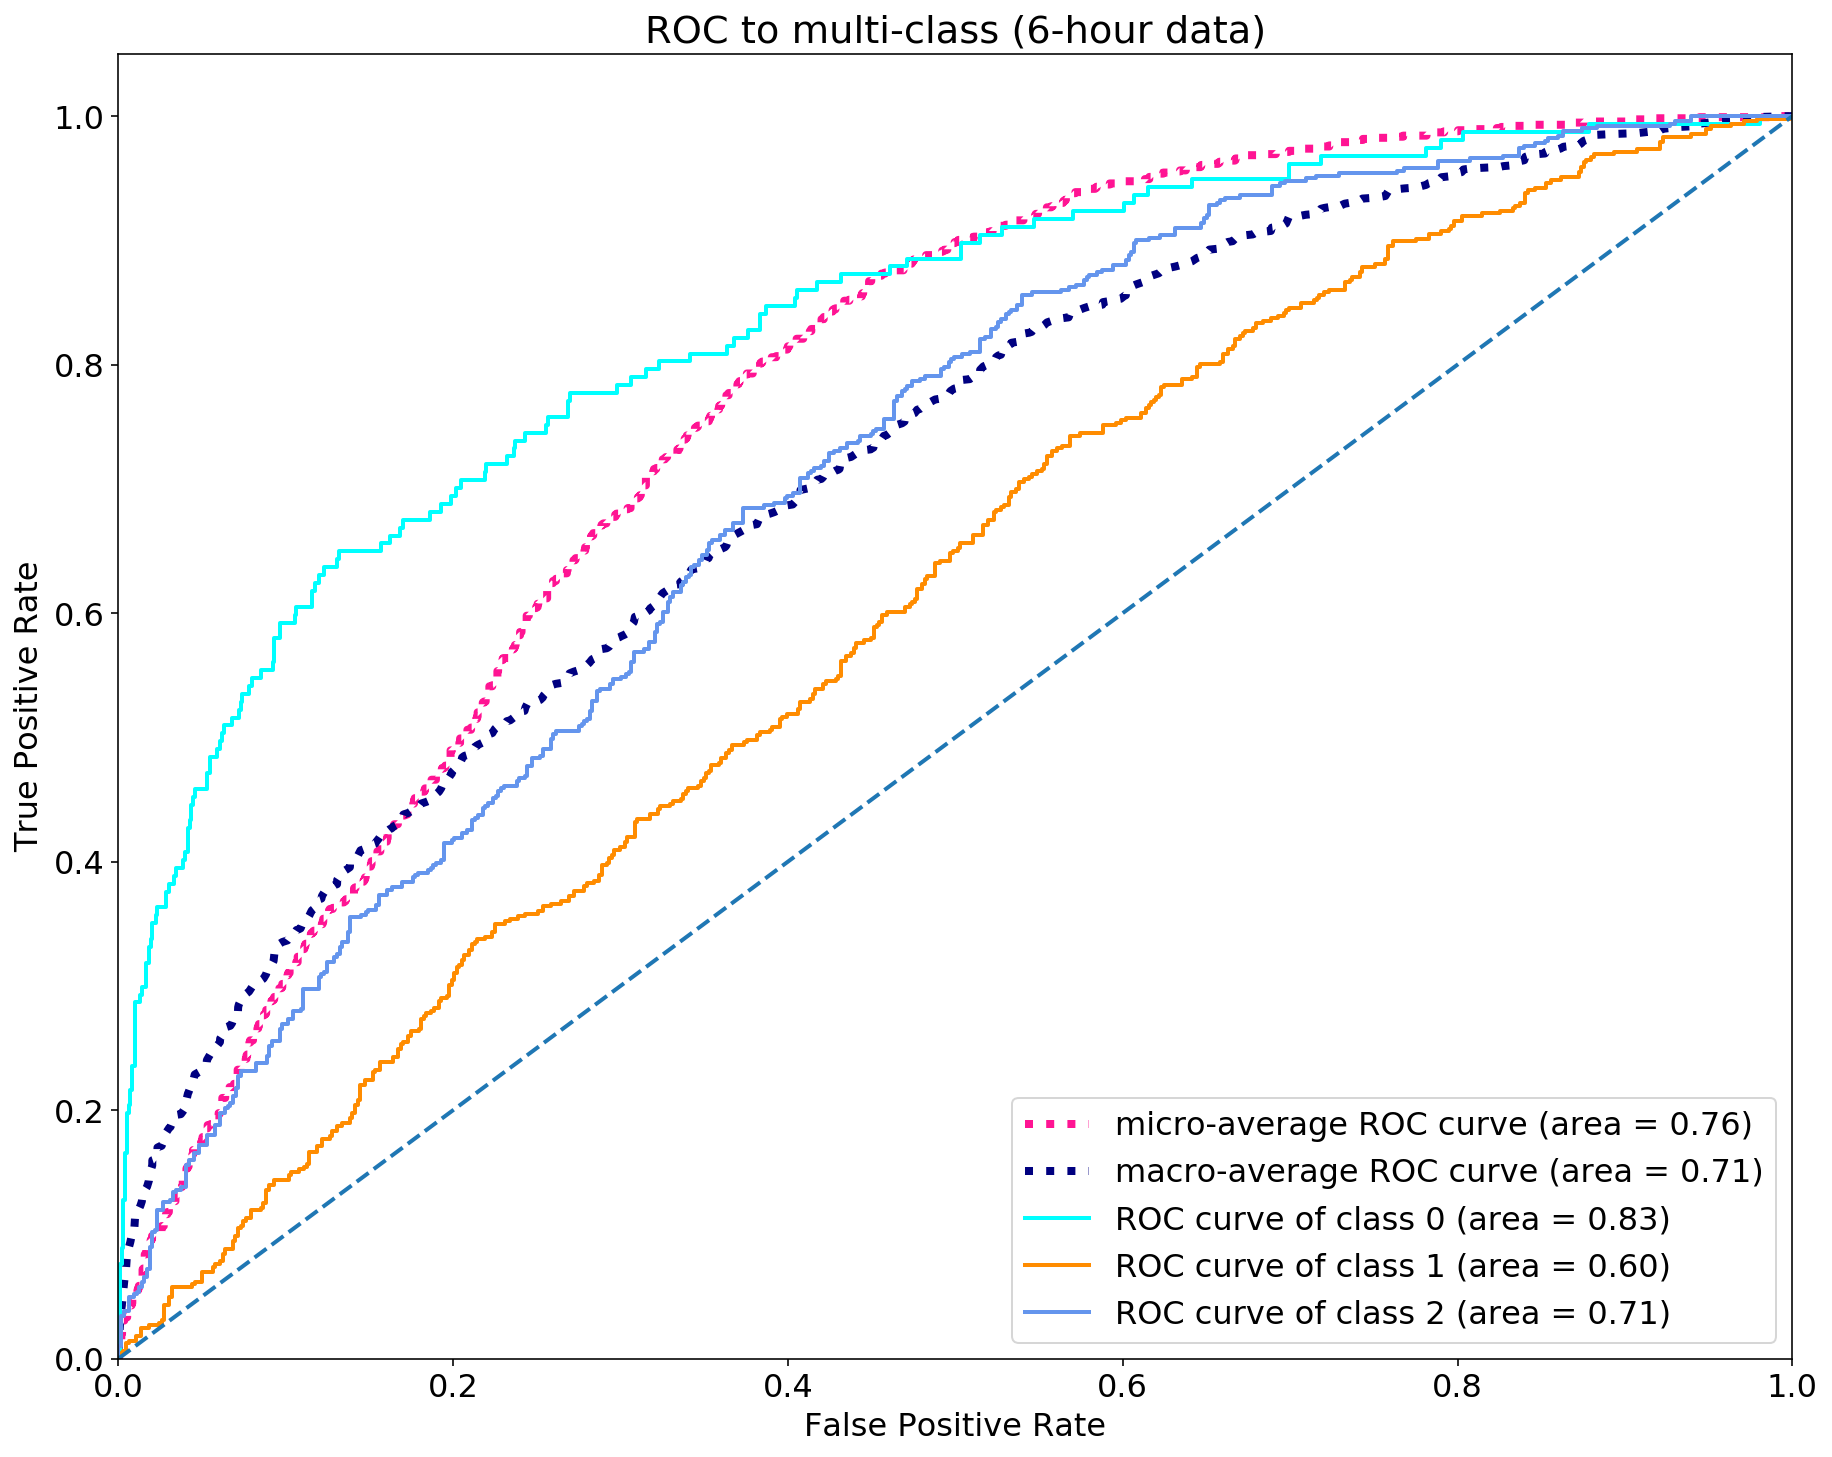

In [22]:
# fit the pipeline using 6-hour data
y_test_6hr, y_score_6hr = train_evaluate_model(df_6hr)

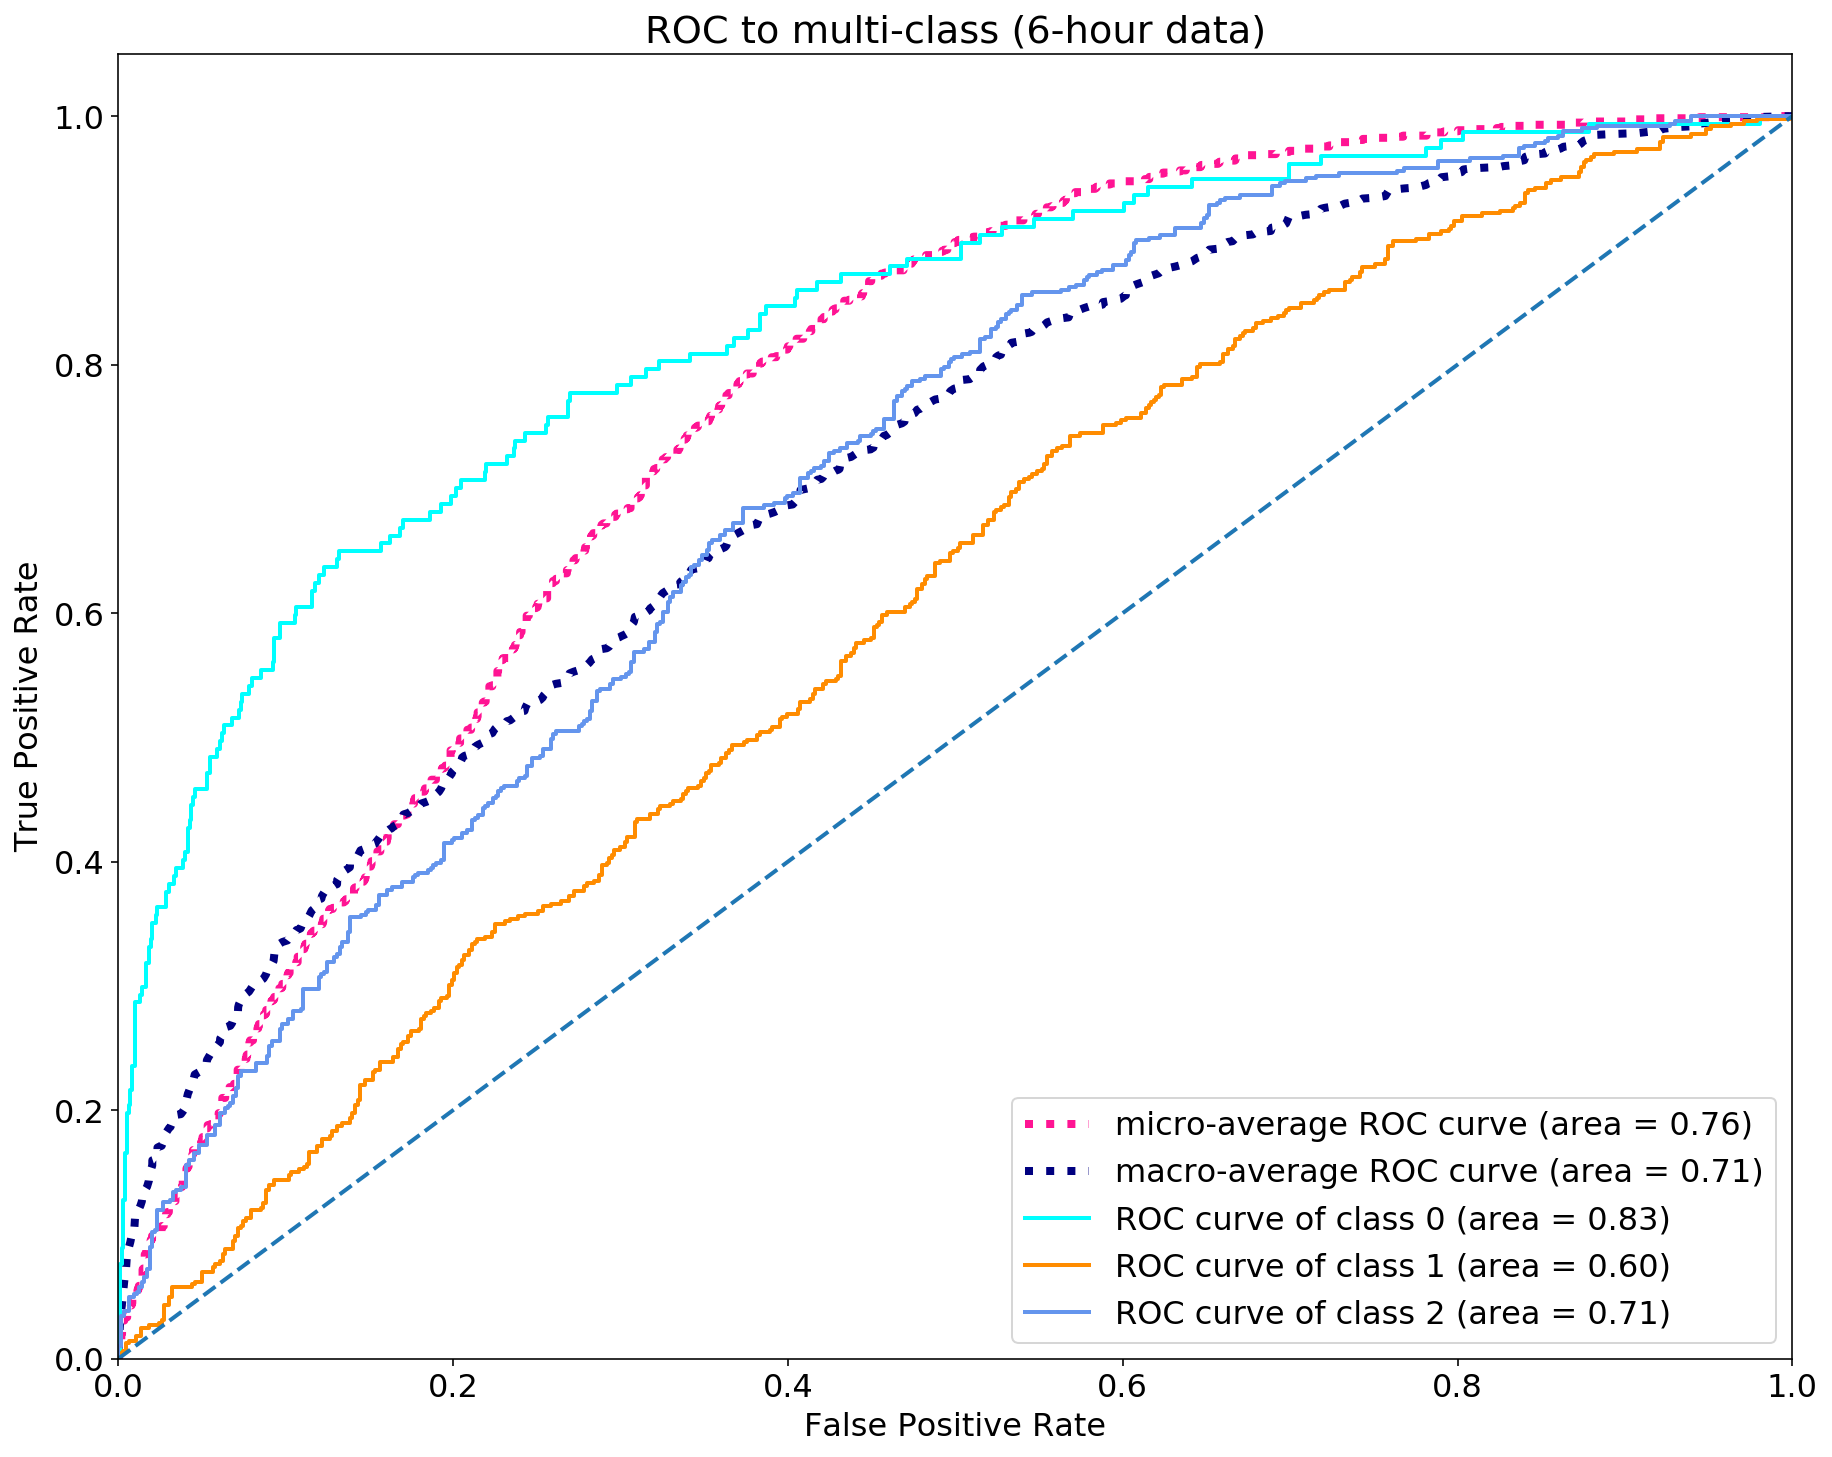

In [23]:
# plot ROC curves for 6-hour data
plot_roc(y_test_6hr, y_score_6hr, 
         plot_title='ROC to multi-class (6-hour data)', filepath='../img/figure3.png')

In [24]:
# fit the pipeline using 12-hour data
y_test_12hr, y_score_12hr = train_evaluate_model(df_12hr)

(49632, 131) (5718, 131)
(4574, 131) (1144, 131)
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  6.8min finished



Grid Search Best parameters set :
{'algorithm__bootstrap': False, 'algorithm__criterion': 'entropy', 'algorithm__max_depth': 10, 'algorithm__max_features': 'log2', 'algorithm__n_estimators': 250}

Best score: 0.566

Grid scores :
0.549 (+/-0.027) for {'algorithm__bootstrap': True, 'algorithm__criterion': 'gini', 'algorithm__max_depth': 5, 'algorithm__max_features': 'auto', 'algorithm__n_estimators': 100}
0.555 (+/-0.027) for {'algorithm__bootstrap': True, 'algorithm__criterion': 'gini', 'algorithm__max_depth': 5, 'algorithm__max_features': 'auto', 'algorithm__n_estimators': 250}
0.552 (+/-0.027) for {'algorithm__bootstrap': True, 'algorithm__criterion': 'gini', 'algorithm__max_depth': 5, 'algorithm__max_features': 'auto', 'algorithm__n_estimators': 500}
0.551 (+/-0.034) for {'algorithm__bootstrap': True, 'algorithm__criterion': 'gini', 'algorithm__max_depth': 5, 'algorithm__max_features': 'sqrt', 'algorithm__n_estimators': 100}
0.550 (+/-0.027) for {'algorithm__bootstrap': True, 'algo

Accuracy : 0.5516
Precision (Micro) : 0.5516
Precision (Macro): 0.6189
Recall (Micro) : 0.5516
Recall (Macro): 0.5216
F1 score (Micro) : 0.5516
F1 score (Macro): 0.5510

Classification report : 
              precision    recall  f1-score   support

          0       0.79      0.42      0.55       157
          1       0.49      0.56      0.52       486
          2       0.58      0.59      0.59       501

avg / total       0.57      0.55      0.55      1144


Confusion matrix : 
 [[ 66  82   9]
 [ 15 271 200]
 [  3 204 294]]
(1144, 3) (1144, 3)


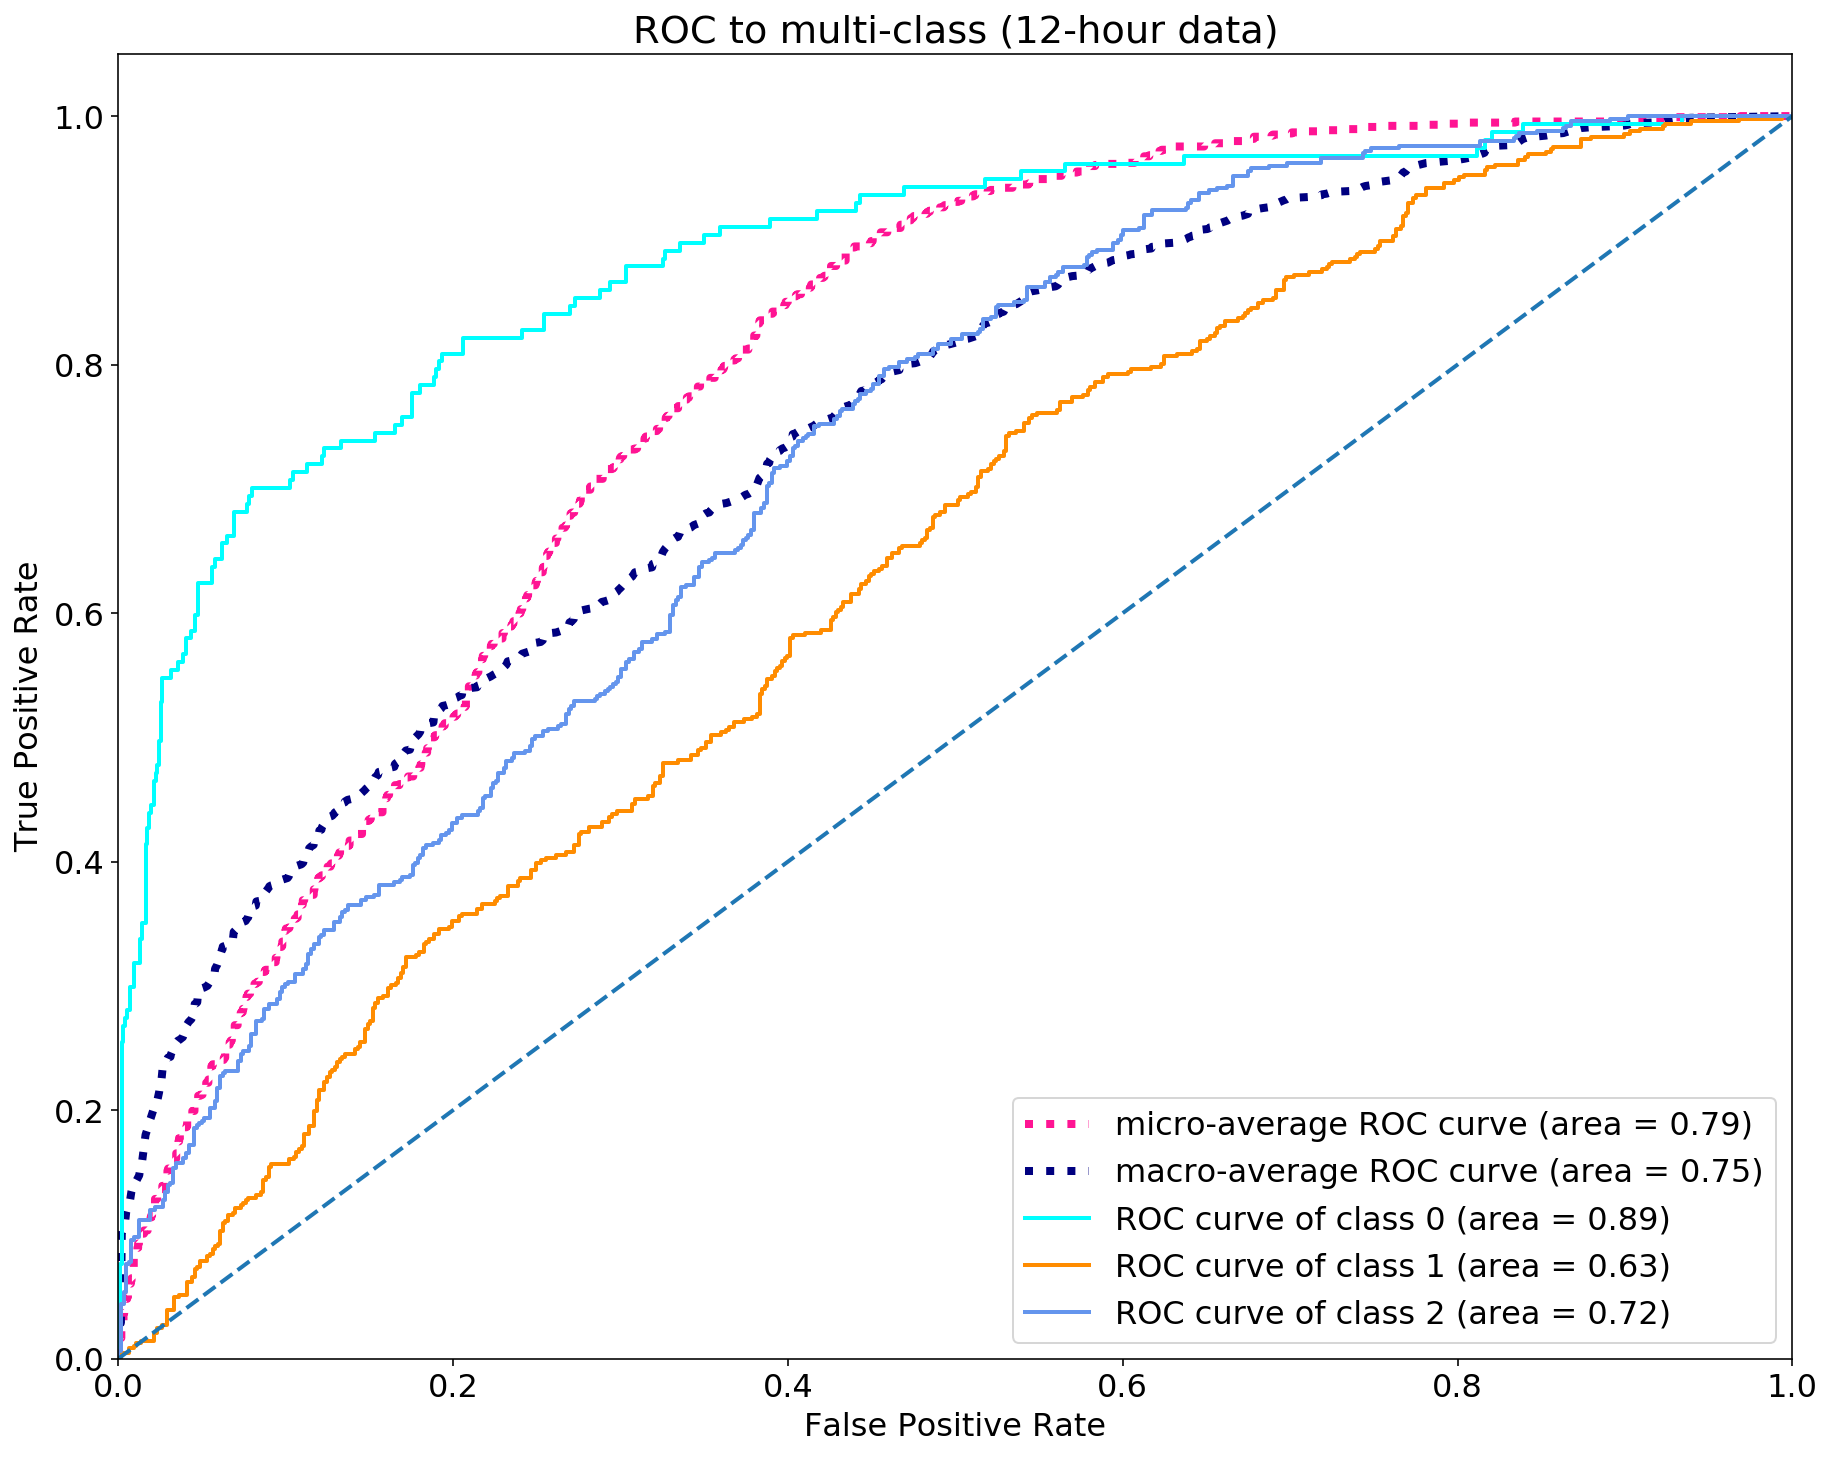

In [25]:
# plot ROC curves for 12-hour data
plot_roc(y_test_12hr, y_score_12hr, 
         plot_title='ROC to multi-class (12-hour data)', filepath='../img/figure4.png')

#### --deleted--

(49633, 131) (5718, 131)


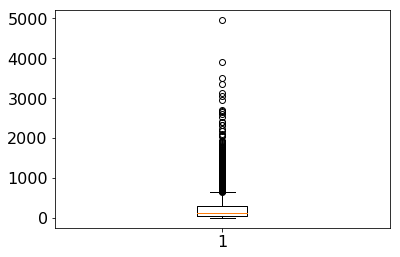

class1 size 838
class2 size 2517
class3 size 2363
(4574, 131) (1144, 131)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.7s remaining:   14.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.8s finished



Grid Search Best parameters set :
{'algorithm__bootstrap': False, 'algorithm__criterion': 'entropy', 'algorithm__max_depth': 30, 'algorithm__max_features': 'log2', 'algorithm__n_estimators': 500}

Best score: 0.554

Grid scores :
0.554 (+/-0.044) for {'algorithm__bootstrap': False, 'algorithm__criterion': 'entropy', 'algorithm__max_depth': 30, 'algorithm__max_features': 'log2', 'algorithm__n_estimators': 500}

Evaluation on Training Set (80%) :
Accuracy : 1.0000
Precision (Micro) : 1.0000
Precision (Macro): 1.0000
Recall (Micro) : 1.0000
Recall (Macro): 1.0000
F1 score (Micro) : 1.0000
F1 score (Macro): 1.0000

Classification report : 
              precision    recall  f1-score   support

          0       1.00      1.00      1.00       681
          1       1.00      1.00      1.00      2031
          2       1.00      1.00      1.00      1862

avg / total       1.00      1.00      1.00      4574


Confusion matrix : 
 [[ 681    0    0]
 [   0 2031    0]
 [   0    0 1862]]

Evaluati

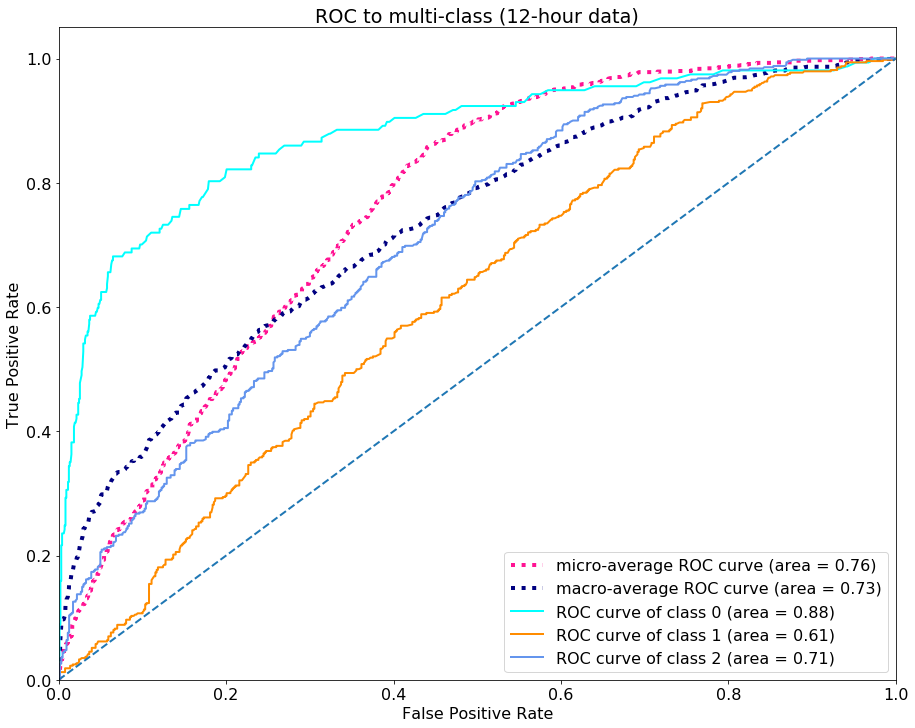

In [49]:
df_12hr = pd.read_csv('data/mp_data_agg_12hr.csv')
y_test_12hr, y_score_12hr = train_model(df_12hr)
plot_roc(y_test_12hr, y_score_12hr)

In [26]:
# fit the pipeline for 24-hour data
y_test_24hr, y_score_24hr = train_evaluate_model(df_24hr)

(49632, 131) (5718, 131)
(4574, 131) (1144, 131)
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  7.0min finished



Grid Search Best parameters set :
{'algorithm__bootstrap': True, 'algorithm__criterion': 'entropy', 'algorithm__max_depth': 10, 'algorithm__max_features': 'log2', 'algorithm__n_estimators': 500}

Best score: 0.604

Grid scores :
0.582 (+/-0.036) for {'algorithm__bootstrap': True, 'algorithm__criterion': 'gini', 'algorithm__max_depth': 5, 'algorithm__max_features': 'auto', 'algorithm__n_estimators': 100}
0.582 (+/-0.039) for {'algorithm__bootstrap': True, 'algorithm__criterion': 'gini', 'algorithm__max_depth': 5, 'algorithm__max_features': 'auto', 'algorithm__n_estimators': 250}
0.584 (+/-0.031) for {'algorithm__bootstrap': True, 'algorithm__criterion': 'gini', 'algorithm__max_depth': 5, 'algorithm__max_features': 'auto', 'algorithm__n_estimators': 500}
0.580 (+/-0.037) for {'algorithm__bootstrap': True, 'algorithm__criterion': 'gini', 'algorithm__max_depth': 5, 'algorithm__max_features': 'sqrt', 'algorithm__n_estimators': 100}
0.585 (+/-0.034) for {'algorithm__bootstrap': True, 'algor

Accuracy : 0.9001
Precision (Micro) : 0.9001
Precision (Macro): 0.9153
Recall (Micro) : 0.9001
Recall (Macro): 0.8952
F1 score (Micro) : 0.9001
F1 score (Macro): 0.9040

Classification report : 
              precision    recall  f1-score   support

          0       0.97      0.87      0.92       681
          1       0.91      0.88      0.89      2031
          2       0.87      0.93      0.90      1862

avg / total       0.90      0.90      0.90      4574


Confusion matrix : 
 [[ 595   61   25]
 [  21 1784  226]
 [   0  124 1738]]

Evaluation on Test Set (20%) :
Accuracy : 0.5944
Precision (Micro) : 0.5944
Precision (Macro): 0.6668
Recall (Micro) : 0.5944
Recall (Macro): 0.5836
F1 score (Micro) : 0.5944
F1 score (Macro): 0.6132

Classification report : 
              precision    recall  f1-score   support

          0       0.86      0.55      0.67       157
          1       0.53      0.58      0.55       486
          2       0.61      0.62      0.62       501

avg / total      

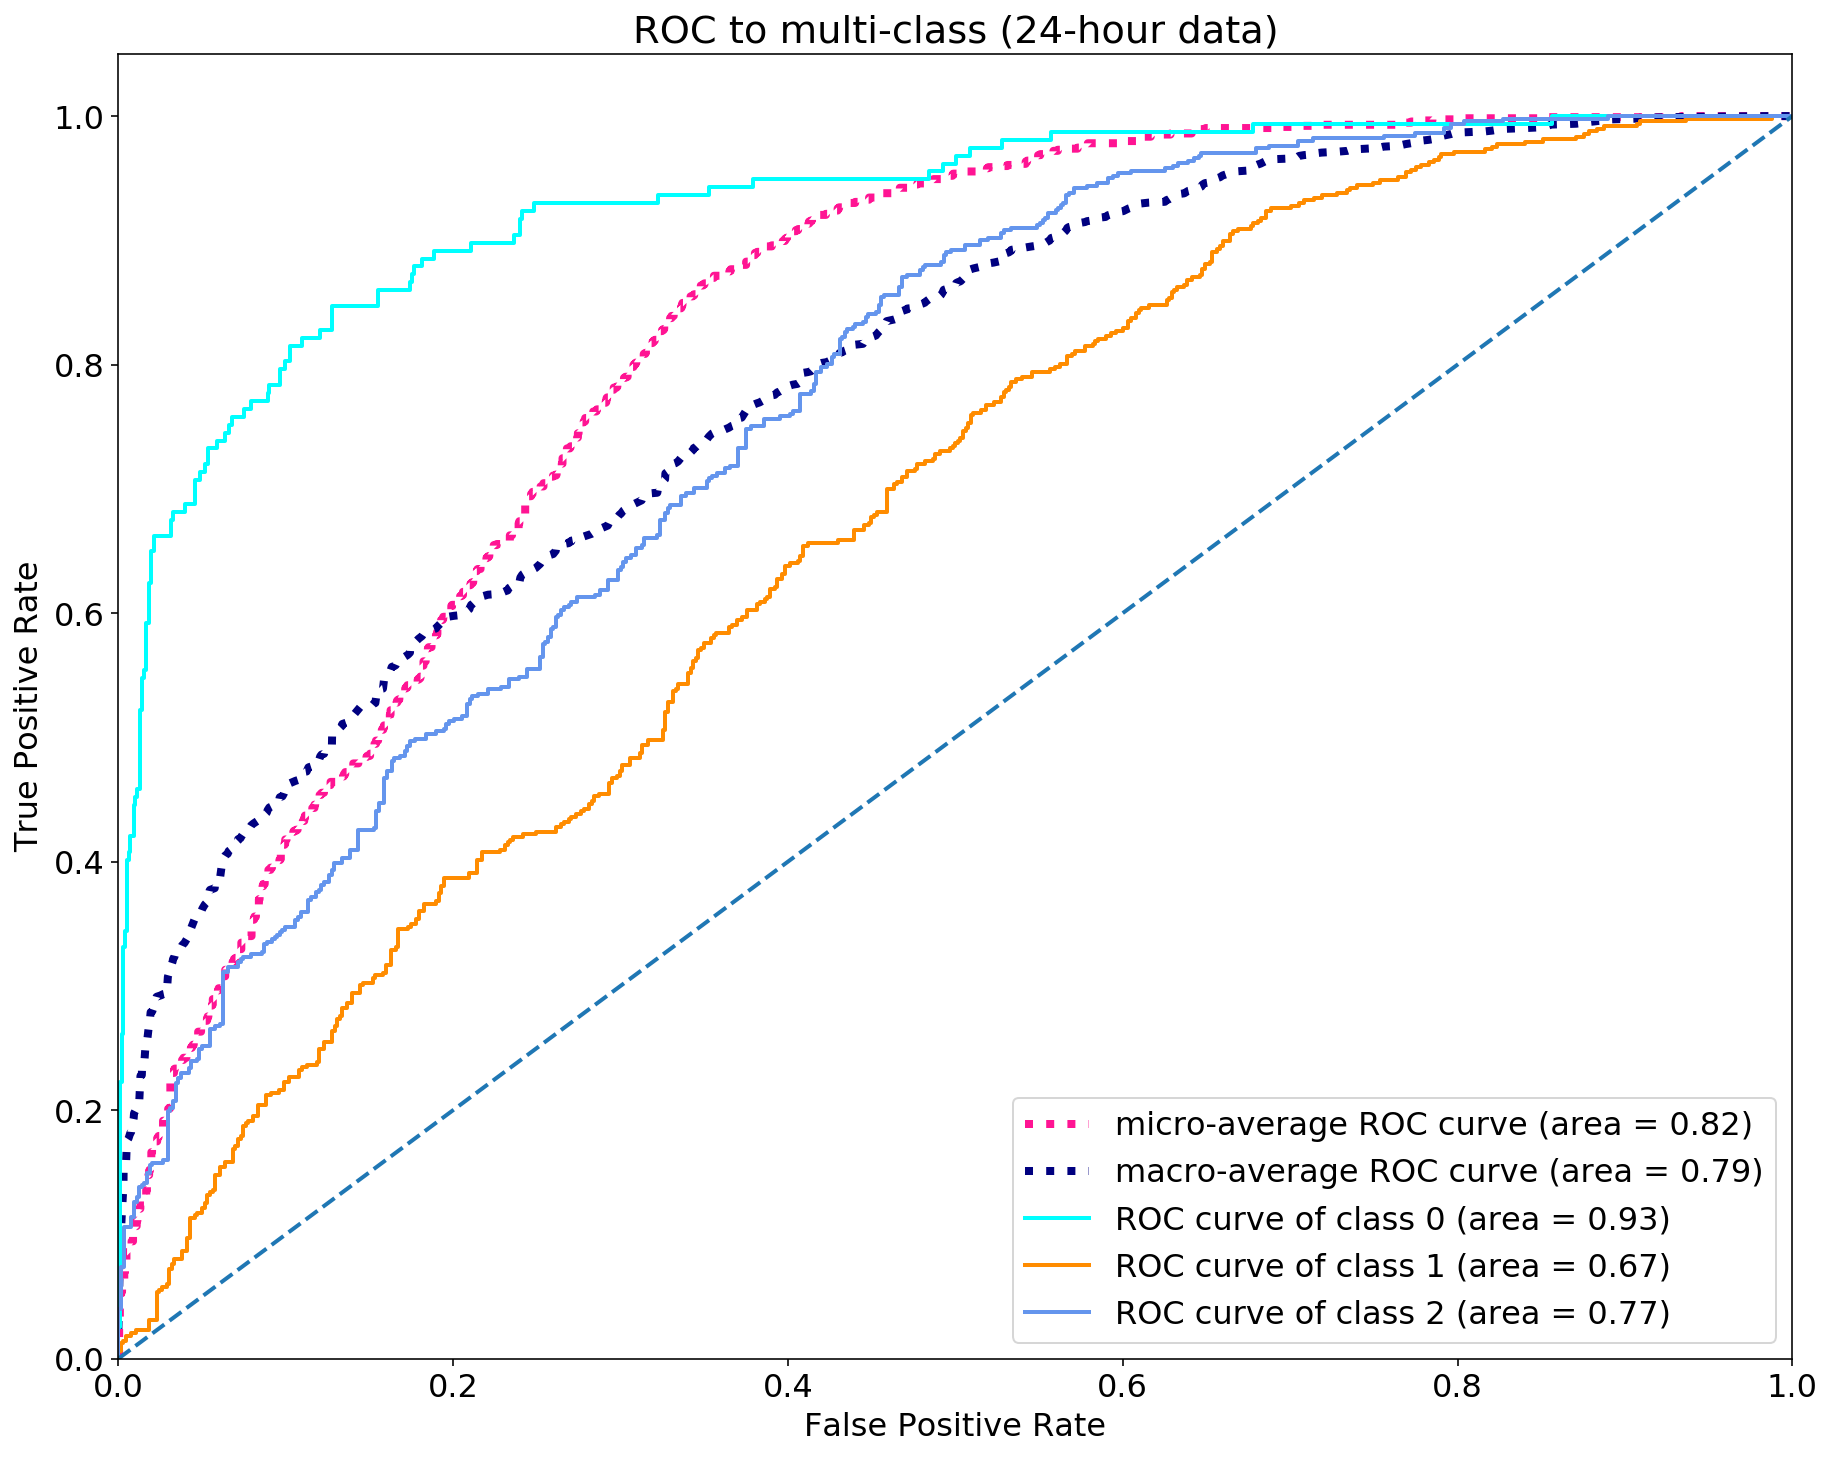

In [27]:
# fit the pipeline using 24-hour data
plot_roc(y_test_24hr, y_score_24hr, 
         plot_title='ROC to multi-class (24-hour data)', filepath='../img/figure5.png')

#### --deleted--

(49633, 131) (5718, 131)


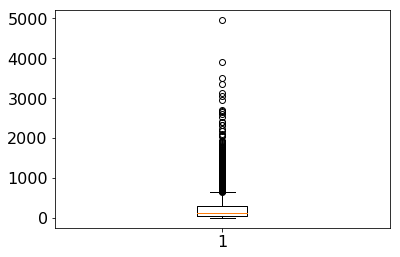

class1 size 838
class2 size 2517
class3 size 2363
(4574, 131) (1144, 131)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   10.0s remaining:   15.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.2s finished



Grid Search Best parameters set :
{'algorithm__bootstrap': False, 'algorithm__criterion': 'entropy', 'algorithm__max_depth': 30, 'algorithm__max_features': 'log2', 'algorithm__n_estimators': 500}

Best score: 0.595

Grid scores :
0.595 (+/-0.030) for {'algorithm__bootstrap': False, 'algorithm__criterion': 'entropy', 'algorithm__max_depth': 30, 'algorithm__max_features': 'log2', 'algorithm__n_estimators': 500}

Evaluation on Training Set (80%) :
Accuracy : 1.0000
Precision (Micro) : 1.0000
Precision (Macro): 1.0000
Recall (Micro) : 1.0000
Recall (Macro): 1.0000
F1 score (Micro) : 1.0000
F1 score (Macro): 1.0000

Classification report : 
              precision    recall  f1-score   support

          0       1.00      1.00      1.00       681
          1       1.00      1.00      1.00      2031
          2       1.00      1.00      1.00      1862

avg / total       1.00      1.00      1.00      4574


Confusion matrix : 
 [[ 681    0    0]
 [   0 2031    0]
 [   0    0 1862]]

Evaluati

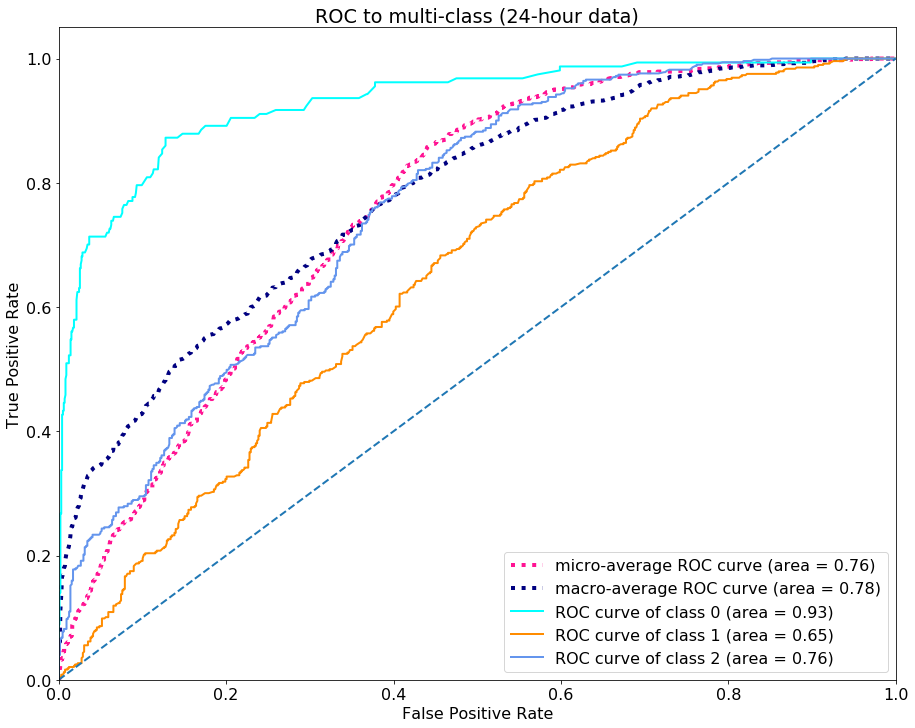

In [47]:
df_24hr = pd.read_csv('data/mp_data_agg_24hr.csv')
y_test_24hr, y_score_24hr = train_model(df_24hr)
plot_roc(y_test_24hr, y_score_24hr)